In [1]:
import sys
# sys.path.insert(0, '/home/gfzg/workspace/数据下载/Wind/Packages')
# sys.path.insert(0, '/home/gfzg/workspace/债券分析/Packages')
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
from importlib import reload
import re
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm   # 这个模块也是进度条
import math
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import janitor   
# 最新版本的janitor需要找到C:\Users\username\anaconda3\Lib\site-packages路径下的janitor.py 
# 把ConfigParser改成configparse
# 把from werkzeug.contrib.fixers import ProxyFix 改成 from werkzeug.middleware.proxy_fix import ProxyFix
import time
# from progressbar import progressbar as pbar # 该用pg进度条了
# from progressbar import *
# pbar = ProgressBar()
from tabulate import tabulate
# 核心包
# import Wind
# import Bonder 
# import Selector
import dolphindb as ddb

import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 显示多行运行结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# DDB数据筛选与合并

In [2]:
# 连接服务器节点
s = ddb.session()
isConnect = s.connect("192.168.100.43", 7988, "admin", "123456")  # 连接数据库
print(isConnect)

True


In [3]:
## 定义DDB代码的函数

script = """

// undef all   // 释放变量
// loadPlugin("/home/hanyang/luodata/PluginParquet.txt")   // 导入插件，导入一次即可

// 打印筛选条件
def slectionString(Filters){   
    print("\n数据筛选中...请稍等")
    print('筛选条件：')
    for(filter in Filters){
        if (size(filter[2]) > 1){     // isin
            print(filter[0] + ' ' + filter[1] + ' ' + concat(filter[2], ', '))
        }
        else if (isNull(filter[2])){   // isna、isnotna
            print(filter[0] + ' ' + filter[1])
        }
        else {   // "==","!=",">=","<=",">","<"
            print(filter[0] + ' ' + filter[1] + ' ' + filter[2])
        }
    }
}


// 筛选数据
def selector(df, Filters){    // 改进方向： 里面嵌一层函数

    if (!(typestr(Filters) == 'ANY VECTOR')) return df 

    data = df
    slectionString(Filters)
    selection = take(true, data.rows())
    for(filter in Filters){
        if (filter[1]=='isin'){
            selection = selection && data[filter[0]] in filter[2]
        }
        else if (filter[1] == 'isna'){
            print(filter[1])
            selection = selection && isNull(data[filter[0]])
        }
        else if (filter[1] == 'isnotna'){
            selection = selection && not isNull(data[filter[0]])
        }
        else if (filter[1] == '=='){
            selection = selection && data[filter[0]] == filter[2] && !isNull(data[filter[0]])
        }
        else if (filter[1] == '!='){
            selection = selection && data[filter[0]] != filter[2] && !isNull(data[filter[0]])
        }
        else if (filter[1] == '>='){
            selection = selection && data[filter[0]] >= filter[2] && !isNull(data[filter[0]])
        }
        else if (filter[1] == '<='){
            selection = selection && data[filter[0]] <= filter[2] && !isNull(data[filter[0]])
        }
        else if (filter[1] == '>'){
            selection = selection && data[filter[0]] > filter[2] && !isNull(data[filter[0]])
        }
        else if (filter[1] == '<'){
            selection = selection && data[filter[0]] < filter[2] && !isNull(data[filter[0]])
        }
        else {
            print('请检查逻辑符号，有效逻辑符号为["==","!=",">=","<=",">","<","isin","isna","isnotna"]')
        }
    }
    data = data[selection]
    // data = data[each(isValid, data.values()).rowAnd()]   // 删除含有缺失值的行
    return data
}


def dataCenter(StaticPath, BondsPath, FilledGuokaiPath, BondStaticFilters, BondDynamicFilters){

    // 静态筛选
    STATIC = parquet::loadParquet(StaticPath)
    STATIC.dropColumns!(`B_INFO_ISSUERCODE)   // 好像没有必要删这一列
    STATIC = selector(df = STATIC, Filters = BondStaticFilters)

    // 动态筛选
    BONDS = parquet::loadParquet(BondsPath) 
    BONDS = selector(df = BONDS, Filters = BondDynamicFilters)   

    // 动态静态结合，并计算信用利差
    df = ej(STATIC, BONDS, `S_INFO_WINDCODE) 
    df['B_ANAL_MATU_CNBD'] = round(df['B_ANAL_MATU_CNBD'], 2)  
    FILLED_GUOKAI = parquet::loadParquet(FilledGuokaiPath)
    df = lj(df, FILLED_GUOKAI, `TRADE_DT`B_ANAL_MATU_CNBD)
    df = select *, B_ANAL_YIELD_CNBD - B_ANAL_YIELD_GUOKAI as CREDIT_SPREAD from df 

    print("数据处理完成")
    return df
}


def preparePlotData(df, Filters, division_label = '', method = [0]){  

    data = df.copy()
    data = data[!isNull(data[division_label])]

    if (isNull(division_label)){
        data['LABEL'] = 'ALL'
    }
    else {
        data['LABEL'] = data[division_label]
    }
    // sum(!isNull(data['LABEL']))

    data = selector(data, Filters)
    data = select * from data order by TRADE_DT, LABEL
    index = select distinct TRADE_DT, LABEL from data
    labels = select distinct LABEL from data
    dailyspread = index

    if(0 in method){
        temp = select mean(CREDIT_SPREAD) * 100 from data group by TRADE_DT, LABEL  
        dailyspread['CREDIT_SPREAD_0'] = temp[,2].values()[0] 
    }
    if(1 in method){
        temp = select median(CREDIT_SPREAD) * 100 from data group by TRADE_DT, LABEL  
        dailyspread['CREDIT_SPREAD_1'] = temp[,2].values()[0]    
    }
    if(2 in method){
        total = select TRADE_DT, LABEL, sum(B_ANAL_RESIDUALPRI) as B_ANAL_RESIDUALPRI_TOTAL from data group by TRADE_DT, LABEL
        temp = lj(data, total, `TRADE_DT`LABEL)
        update temp set CREDIT_SPREAD = B_ANAL_RESIDUALPRI / B_ANAL_RESIDUALPRI_TOTAL * CREDIT_SPREAD 
        temp = select sum(CREDIT_SPREAD) * 100 as CREDIT_SPREAD_2 from temp group by TRADE_DT, LABEL
        dailyspread['CREDIT_SPREAD_2'] = temp[,2].values()[0]     
    }
    return dailyspread
}

"""

s.run(script)

In [4]:
# 上传参数

s.upload({
    'StaticPath': "/home/hanyang/luodata/STATIC.parquet",
    'BondsPath': "/home/hanyang/luodata/BONDS.parquet",
    'FilledGuokaiPath': "/home/hanyang/luodata/FILLED_GUOKAI.parquet",
    'BondStaticFilters': [
        ('suffix', 'isin', ['IB', 'SH', 'SZ']),
        ('CATEGORY1', '==', '信用债'),
        ('isPerpetualBonds', '==', 0),
        ('IS_FAILURE', '==', 0)
    ],
    'BondDynamicFilters': [('B_ANAL_MATU_CNBD', '<=', 10)]
}  
)  

s.upload({'Filters' : [('BOND_TYPE','==','产业债')],
'division_label': 'S_INFO_COMPIND_NAME1',
'method': [0,1,2]
}
)

[2406701872, 2406636960, 2312967952, 1359372928, 3498650368]

[1165138304, 2406676288, 3434396160]

In [5]:
script = """
df = dataCenter(StaticPath, BondsPath, FilledGuokaiPath, BondStaticFilters, BondDynamicFilters)
"""

s2 = "dailyspread = preparePlotData(df, Filters, division_label , method)"

s.run(script + s2)

In [6]:
df = s.run("df")   
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050227 entries, 0 to 1050226
Data columns (total 47 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   S_INFO_WINDCODE                 1050227 non-null  object 
 1   B_INFO_FULLNAME                 1050227 non-null  object 
 2   B_INFO_ISSUER                   1050227 non-null  object 
 3   B_INFO_CARRYDATE                1050227 non-null  object 
 4   B_INFO_MATURITYDATE             1050227 non-null  object 
 5   B_INFO_TERM_YEAR_               1050227 non-null  float64
 6   B_INFO_PAYMENTTYPE              1050227 non-null  object 
 7   S_INFO_EXCHMARKET               1050227 non-null  object 
 8   B_INFO_INTERESTFREQUENCY        1050227 non-null  object 
 9   IS_FAILURE                      1050227 non-null  float64
 10  B_INFO_GUARTYPE                 1050227 non-null  float64
 11  IS_CORPORATE_BOND               1050227 non-null  float64
 12  

,S_INFO_WINDCODE,B_INFO_FULLNAME,B_INFO_ISSUER,B_INFO_CARRYDATE,B_INFO_MATURITYDATE,B_INFO_TERM_YEAR_,B_INFO_PAYMENTTYPE,S_INFO_EXCHMARKET,B_INFO_INTERESTFREQUENCY,IS_FAILURE,B_INFO_GUARTYPE,IS_CORPORATE_BOND,B_INFO_ISSUERTYPE,B_INFO_ISSUETYPE,suffix,S_INFO_INDUSTRYNAME_WindLevel1,S_INFO_INDUSTRYNAME_WindLevel2,CATEGORY1,CATEGORY2,CATEGORY3,isPerpetualBonds,isTier2CapitalBonds,BOND_TYPE,B_AGENCY_GUARANTORNATURE,S_INFO_COMPIND_NAME1,S_INFO_COMPIND_NAME2,S_INFO_COMPIND_NAME3,S_INFO_COMPIND_NAME4,PROVINCE,CITY,DISTRICT,AREA,ADMINISTRATIVE_LEVEL,IS_SUB,__index_level_0__,TRADE_DT,B_ANAL_MATU_CNBD,B_ANAL_YIELD_CNBD,B_ANAL_RESIDUALPRI,CNBD_HIDDEN_CREDITRATING,B_INFO_CREDITRATING_BOND,B_INFO_ISSUERCODE,B_INFO_CREDITRATING_ISSUER,B_ANAL_MATU_CNBD_YEAR,data___index_level_0__,B_ANAL_YIELD_GUOKAI,CREDIT_SPREAD
0,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,14987,20220104,0.57,2.6754,100.0,AAA,AAA,2002227,AAA,1.0,99017,9.87239,-7.19699
1,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,14987,20220105,0.57,2.6571,100.0,AAA,AAA,2002227,AAA,1.0,99018,9.86199,-7.20489
2,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,14987,20220106,0.56,2.6319,100.0,AAA,AAA,2002227,AAA,1.0,99019,9.84668,-7.21478
3,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,14987,20220107,0.56,2.6493,100.0,AAA,AAA,2002227,AAA,1.0,99020,9.84458,-7.19528
4,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,14987,20220110,0.55,2.6501,100.0,AAA,AAA,2002227,AAA,1.0,99021,9.84960,-7.19950


# 时序图像绘制

In [7]:
dailyspread = s.run("dailyspread")
dailyspread.info()
dailyspread.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3456 entries, 0 to 3455
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TRADE_DT         3456 non-null   object 
 1   LABEL            3456 non-null   object 
 2   CREDIT_SPREAD_0  3424 non-null   float64
 3   CREDIT_SPREAD_1  3424 non-null   float64
 4   CREDIT_SPREAD_2  3424 non-null   float64
dtypes: float64(3), object(2)
memory usage: 135.1+ KB


,TRADE_DT,LABEL,CREDIT_SPREAD_0,CREDIT_SPREAD_1,CREDIT_SPREAD_2
0,20220104,公用事业,-502.499500,-688.9850,-538.807211
1,20220104,可选消费,-180.889857,-243.6300,-332.207421
2,20220104,工业,-529.198730,-617.3985,-486.487479
3,20220104,房地产,-460.448905,-597.1250,-507.879930
4,20220104,日常消费,-433.875000,-433.8750,-433.875000


In [40]:
# 参数   
methodDict = {
    0: '简单平均',
    1: '中位数',
    2: '余额加权平均',
}
config = {
    'date':'20230821', # 截面日期
    'plotCrossSection':True, # 是否绘制date时间的柱状截面图
}
methods = [0]  # methods 0: 简单平均 1: 中位数 2: 剩余本金加权
# methods = [0, 1, 2]

# 以下两个参数注意和DDB中的参数保持一样
divisionLabel = 'S_INFO_COMPIND_NAME1' # 根据这个字段的类别画线
filters = [
    ('BOND_TYPE','==','产业债'),
]

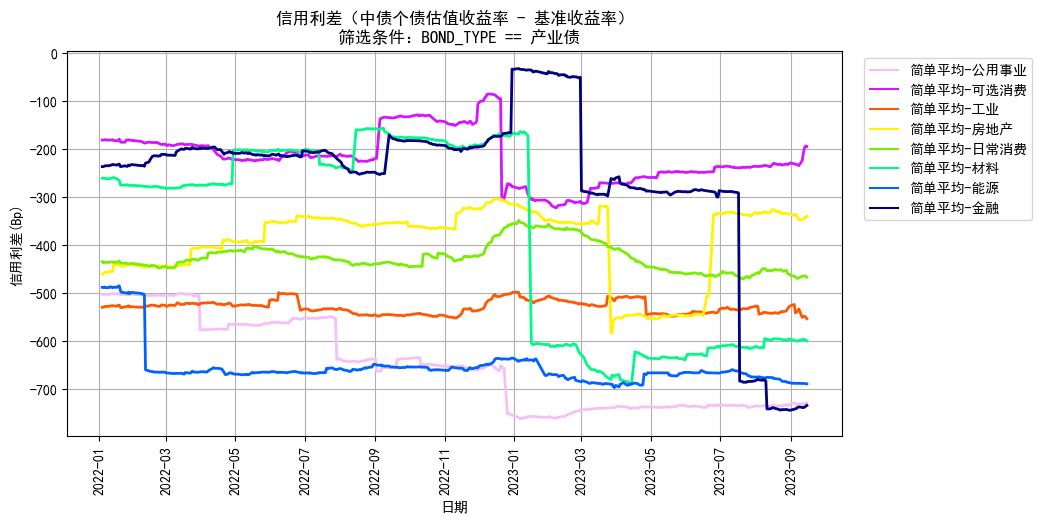

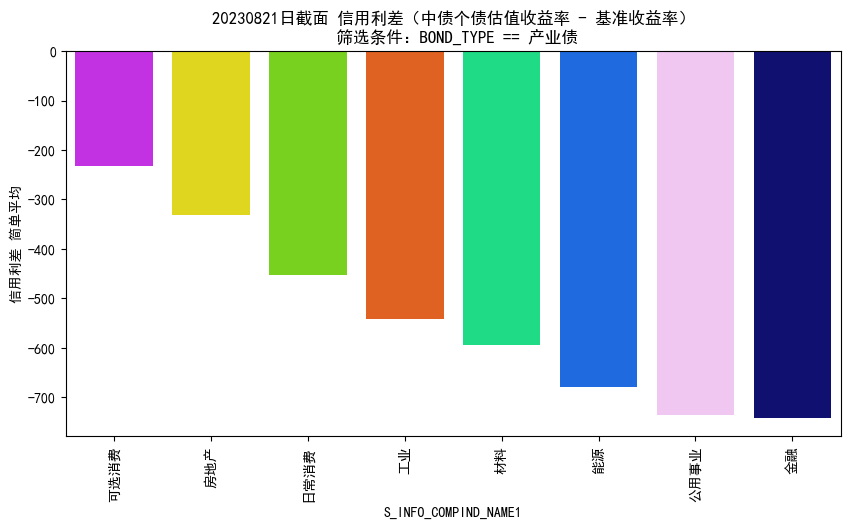

In [41]:
# 显示筛选条件
def slectionString(Filters):
    
    def parse_tuple_condition(x):
        x = [str(i) for i in list(x)]
        return ' '.join(x)
    
    condition = ''
    for filter in Filters:
        if condition != '': condition+=' and '
        if type(filter) is tuple:  #and
            string = parse_tuple_condition(filter)
            condition +=  string
        elif type(filter) is list:  #or
            strings = ''
            for fil in filter:
                string = parse_tuple_condition(fil)
                if strings == '': strings = string
                else: strings +=  (' or '+ string)
            condition += '(' + strings + ')'
    return condition

labels = dailyspread['LABEL'].unique()
lengths = (len(methods),len(labels))
mus = np.linspace(100,2000,lengths[0]*lengths[1])
cmap = plt.cm.gist_ncar
palette_raw = dict()
palette = dict()
palette_reverse = dict()
for i in range(lengths[0]):
    method = methods[i]
    for j in range(lengths[1]):
        label = labels[j]
        mu = mus[i*lengths[1]+j]
        color = cmap(1-mu/np.max(mus))  
        hue = methodDict[method]+'-'+str(label)
        palette[hue] = color
        palette_raw[label] = color
        palette_reverse[color] = hue

# 删除名为 'level_0' 的列  用DDB读取会自动生成
if 'level_0' in dailyspread.columns:
    dailyspread.drop('level_0', axis=1, inplace=True)

dailyspread = dailyspread.reset_index()
dailyspread['TRADE_DT_DATETIME'] = pd.to_datetime(dailyspread['TRADE_DT'])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5), dpi=100)
for i in methods:
    sns.lineplot(data=dailyspread, x="TRADE_DT_DATETIME", y=f"CREDIT_SPREAD_{i}",hue=methodDict[i]+'-'+dailyspread["LABEL"].astype(str),linewidth = 2, palette=palette)

conditionString = slectionString(filters)
ax.set_xlabel('日期')
ax.set_ylabel('信用利差(Bp)')   
ax.set_title(f"信用利差（中债个债估值收益率 - 基准收益率）\n 筛选条件：{conditionString if conditionString else '不筛选'}")
ax.tick_params(axis='x', rotation=90)
for i in range(len(ax.get_xticklabels())):
    tick = ax.get_xticklabels()[i]
plotCrossSection = config['plotCrossSection']
if plotCrossSection:
    bardata = dailyspread.loc[dailyspread['TRADE_DT'] == config['date']]
    fig, barax = plt.subplots(ncols=1, nrows=1, figsize=(10,5), dpi=100)
    order = bardata.sort_values([f"CREDIT_SPREAD_{methods[0]}"],ascending=False)['LABEL'].values
    sns.barplot(data=bardata, x='LABEL', y=f"CREDIT_SPREAD_{methods[0]}",ci=False, ax=barax, order=order,palette=palette_raw)
    barax.set_xlabel(divisionLabel)
    barax.set_ylabel(f'信用利差 {methodDict[methods[0]]}')   
    barax.set_title(f"{config['date']}日截面 信用利差（中债个债估值收益率 - 基准收益率）\n 筛选条件：{conditionString if conditionString else '不筛选'}")
    barax.tick_params(axis='x', rotation=90)
    for i in range(len(barax.get_xticklabels())):
        tick = barax.get_xticklabels()[i]

ax.grid()
ax.legend(loc=0, ncol=1, bbox_to_anchor=[1.02,1,0,0])
plt.show() ;

# 个债预警

In [10]:
def showSingleBond(data, bond_codes=[], YIELD_CHANGE_PERIOD=7,QUANTILE=0.95,ROLLING_WINDOW=250,ALARM_PERIOD=20,TODAY='20230921',config={'plot':True,'plot_abs':True}):
    plot= config['plot']
    pos_res = []
    neg_res = []
    for bond_code in tqdm(bond_codes):
        single_bond = data.loc[bond_code]
        single_bond = single_bond.loc[single_bond['TRADE_DT']<=TODAY]
        if single_bond.shape[0] < ROLLING_WINDOW:
            continue
        single_bond = single_bond.reset_index()
        single_bond['ACC_YIELD_CHANGE'] = (single_bond['B_ANAL_YIELD_CNBD'] - single_bond['B_ANAL_YIELD_CNBD'].shift(YIELD_CHANGE_PERIOD)) * 100 #bp
        single_bond['ACC_YIELD_CHANGE_ABS'] = single_bond['ACC_YIELD_CHANGE'].abs()
        quantile = single_bond['ACC_YIELD_CHANGE_ABS'].rolling(ROLLING_WINDOW,1).apply(lambda x: np.nanquantile(x.values,QUANTILE,interpolation='linear'))

        if plot:
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5), dpi=100)
            single_bond['TRADE_DT_DATETIME'] = pd.to_datetime(single_bond['TRADE_DT'])
            plot_abs = config['plot_abs']
            if plot_abs:
                sns.lineplot(data=single_bond, x=f"TRADE_DT_DATETIME", y=f"ACC_YIELD_CHANGE_ABS",linewidth = 2)
            else:
                sns.lineplot(data=single_bond, x=f"TRADE_DT_DATETIME", y=f"ACC_YIELD_CHANGE",linewidth = 2)
            sns.lineplot(x=single_bond['TRADE_DT_DATETIME'], y=quantile, ax = ax, label=f'过去250天 {str(int(QUANTILE*100))} quantile',linewidth=2,color='blue', linestyle='--')
            if not plot_abs:
                sns.lineplot(x=single_bond['TRADE_DT_DATETIME'], y=-quantile, ax = ax,linewidth=2,color='blue', linestyle='--')
            ax.set_title(f'当天存续债{bond_code}历史信用利差走势图')
            ax.set_ylabel(f'{TODAY}过去{YIELD_CHANGE_PERIOD}天累计变动 BP')
            ax.set_xlabel(f'日期')
            ax.grid()
            plt.show()

        
        single_bond_alarm_period_data = single_bond[-ALARM_PERIOD:]
        quantile_alarm_period_data = quantile[-ALARM_PERIOD:]
        SEL = single_bond_alarm_period_data.loc[
            single_bond_alarm_period_data['ACC_YIELD_CHANGE_ABS'] >= quantile_alarm_period_data
        ]
        if SEL.shape[0]>=1:
            if SEL['ACC_YIELD_CHANGE'].values[-1] >= 0 :
                pos_res.append([bond_code,SEL['TRADE_DT'].values[-1],SEL['ACC_YIELD_CHANGE'].values[-1],quantile.values[-1]])
            else:
                neg_res.append([bond_code,SEL['TRADE_DT'].values[-1],SEL['ACC_YIELD_CHANGE'].values[-1],quantile.values[-1]])
            if plot: print('ALARM!!!')
    POS_RES_DF = pd.DataFrame(pos_res,columns=['S_INFO_WINDCODE','最近突破日期','突破时变化程度bp','绝对预警线bp']).sort_values('最近突破日期',ascending=False).reset_index(drop=True)
    NEG_RES_DF = pd.DataFrame(neg_res,columns=['S_INFO_WINDCODE','最近突破日期','突破时变化程度bp','绝对预警线bp']).sort_values('最近突破日期',ascending=False).reset_index(drop=True)
    
            
    return POS_RES_DF, NEG_RES_DF    

# 监测特定日期的价格异动债券   输入合并后的df数据  然后返回股票代码 和 一些信息(?
def initBondAlarms(data,YIELD_CHANGE_PERIOD=7,QUANTILE=0.95,ROLLING_WINDOW=250,ALARM_PERIOD=20,config={}):
    # config = {
    #     'TODAY':''
    # }
    TODAY = config['TODAY']
    
    data = copy.deepcopy(data)
    data = data.sort_values(['S_INFO_WINDCODE','TRADE_DT']).set_index('S_INFO_WINDCODE')   #wind数据库标识码
    print(f'开始检测最近{ALARM_PERIOD}日出现超越{YIELD_CHANGE_PERIOD}日累计估值收益变动的绝对值在历史{ROLLING_WINDOW}日内的{QUANTILE}分位数的{TODAY}债券')
    
    # 今天有哪些债券需要检验
    bond_codes = data.loc[
        (data['TRADE_DT']==TODAY) &
        (data['B_ANAL_MATU_CNBD']>0)
    ].index.unique()
    showBondConfig = {
        'plot':False,
    }
    df_alarmed_pos_bond,df_alarmed_neg_bond = showSingleBond(
        data=data,
        bond_codes=bond_codes,
        YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD,
        QUANTILE=QUANTILE,
        ROLLING_WINDOW=ROLLING_WINDOW,
        ALARM_PERIOD=ALARM_PERIOD,
        TODAY = TODAY,
        config=showBondConfig
    )
    
    alarmed_pos_bond_codes,alarmed_neg_bond_codes = df_alarmed_pos_bond['S_INFO_WINDCODE'].values, df_alarmed_neg_bond['S_INFO_WINDCODE'].values

    ALARMED_POS_BONDS = data.loc[
        (data.index.isin(alarmed_pos_bond_codes))
    ]
    ALARMED_NEG_BONDS = data.loc[
        (data.index.isin(alarmed_neg_bond_codes))
    ]

    RES = {
        'df_alarmed_pos_bond':df_alarmed_pos_bond,
        'df_alarmed_neg_bond':df_alarmed_neg_bond,
        'alarmed_pos_bond_codes':alarmed_pos_bond_codes,
        'alarmed_neg_bond_codes':alarmed_neg_bond_codes,
        'ALARMED_POS_BONDS':ALARMED_POS_BONDS,
        'ALARMED_NEG_BONDS':ALARMED_NEG_BONDS
    }
    return RES


In [11]:
# Mac 3500个债 约90s Windows较慢 4mins30s
# 债券累计存续时常小于250天不预警
YIELD_CHANGE_PERIOD=7
QUANTILE=0.98
ROLLING_WINDOW=250
ALARM_PERIOD=20
alarmConfig = {
    'TODAY':'20230821' #扫描哪天的存续债
}
ALARMRES = initBondAlarms(
    df,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD, # 累计收益周期
    QUANTILE=QUANTILE, # 预警分位数
    ROLLING_WINDOW=ROLLING_WINDOW, # 历史分位窗口
    ALARM_PERIOD=ALARM_PERIOD, # 预警窗口
    config=alarmConfig
)

开始检测最近20日出现超越7日累计估值收益变动的绝对值在历史250日内的0.98分位数的20230821债券


In [12]:
df_alarmed_pos_bond = ALARMRES['df_alarmed_pos_bond']
df_alarmed_neg_bond = ALARMRES['df_alarmed_neg_bond']
alarmed_pos_bond_codes = ALARMRES['alarmed_pos_bond_codes']
alarmed_neg_bond_codes = ALARMRES['alarmed_neg_bond_codes']
ALARMED_POS_BONDS = ALARMRES['ALARMED_POS_BONDS']
ALARMED_NEG_BONDS = ALARMRES['ALARMED_NEG_BONDS']
df_alarmed_pos_bond, df_alarmed_neg_bond # 最近突破日期在

(  S_INFO_WINDCODE    最近突破日期  突破时变化程度bp  绝对预警线bp
 0       152476.SH  20230807      56.77  48.8496
 1       152865.SH  20230807      57.26  55.4630
 2      2080133.IB  20230807      56.77  48.8496
 3      2180185.IB  20230807      57.26  55.4630
 4       152681.SH  20230731      51.77  50.0410
 5       152924.SH  20230731      49.96  48.2940
 6      2080396.IB  20230731      51.77  50.0410
 7      2180237.IB  20230731      49.96  48.2940,
    S_INFO_WINDCODE    最近突破日期  突破时变化程度bp   绝对预警线bp
 0        127586.SH  20230821    -385.28  205.8556
 1       1980009.IB  20230821    -110.00   74.8644
 2        139251.SH  20230821    -103.00   79.9780
 3        152077.SH  20230821    -110.00   74.8644
 4       1680412.IB  20230821    -103.00   79.9780
 5       1724020.IB  20230821    -385.28  205.8556
 6        152119.SH  20230817     -71.98   54.6828
 7       1780379.IB  20230817     -56.43   54.7986
 8        127715.SH  20230817     -56.43   54.7986
 9       1980040.IB  20230817     -71.98   54.68

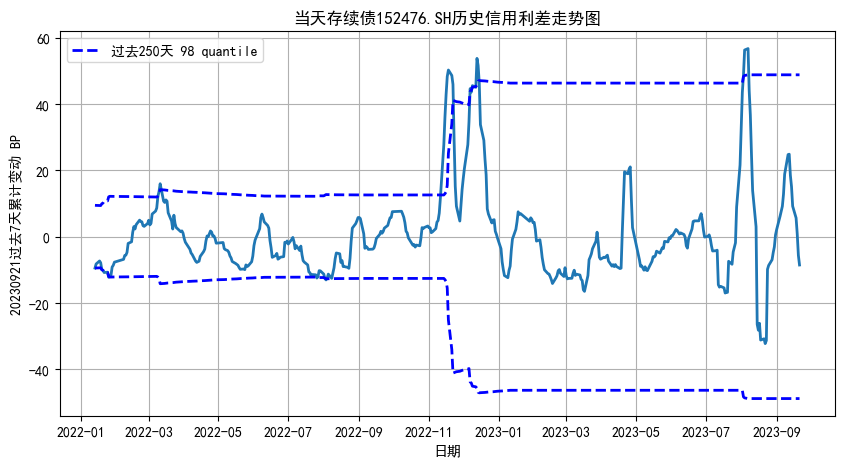

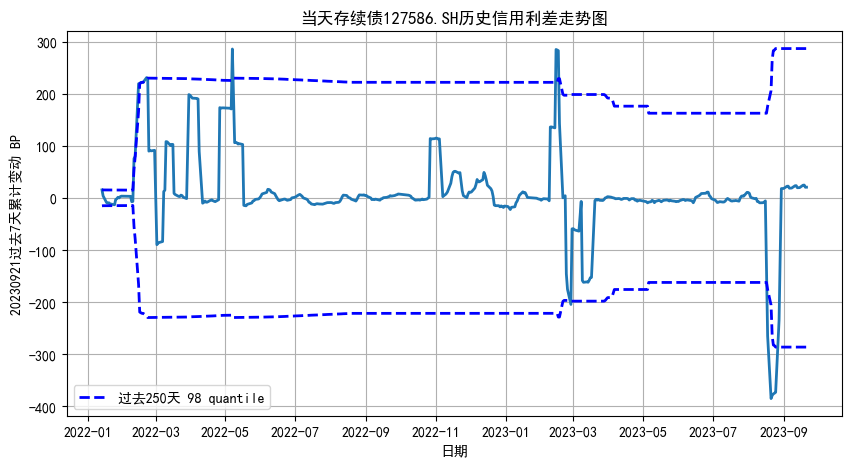

ALARM!!!



In [13]:
SHOW_POS_BONDS = list(ALARMED_POS_BONDS.index.unique())[:1]
SHOW_NEG_BONDS = list(ALARMED_NEG_BONDS.index.unique())[:1]
config = {
    'plot':True,
    'plot_abs':False,
}
POS_SUMMARY,_= showSingleBond(
    data=ALARMED_POS_BONDS, 
    bond_codes=SHOW_POS_BONDS,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD, 
    QUANTILE=QUANTILE,
    ROLLING_WINDOW=ROLLING_WINDOW,
    ALARM_PERIOD=ALARM_PERIOD,
    TODAY = '20230921',
    config=config
)
_,NEG_SUMMARY = showSingleBond(
    data=ALARMED_NEG_BONDS, 
    bond_codes=SHOW_NEG_BONDS,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD,
    QUANTILE=QUANTILE,
    ROLLING_WINDOW=ROLLING_WINDOW,
    ALARM_PERIOD=ALARM_PERIOD,
    TODAY = '20230921',
    config=config
)

In [14]:
POS_SUMMARY

,S_INFO_WINDCODE,最近突破日期,突破时变化程度bp,绝对预警线bp


In [15]:
NEG_SUMMARY

,S_INFO_WINDCODE,最近突破日期,突破时变化程度bp,绝对预警线bp
0,127586.SH,20230825,-373.18,286.4892


# 热力图

In [38]:
# 执行筛选
def select(data,Filters):
    if Filters == None: return data
    def compare(Series,value,symbol='=='):
        if symbol == '==':
            return (Series==value).values
        elif symbol == '!=':
            return (Series!=value).values
        elif symbol == '>=':
            return (Series>=value).values
        elif symbol == '<=':
            return (Series<=value).values
        elif symbol == '>':
            return (Series>value).values
        elif symbol == '<':
            return (Series<value).values
        elif symbol == 'isin':
            return (Series.isin(value)).values
        elif symbol == 'isna':
            return (Series.isna()).values
        elif symbol == 'isnotna':
            return (~Series.isna()).values
        else:
            print('请检查逻辑符号，有效逻辑符号为["==","!=",">=","<=",">","<","isin","isna","isnotna"]')
            return np.array([False]*len(Series))        

    
    print('数据筛选中...请等待')
    final_selection = np.array([True] * data.shape[0])
    for filter in Filters:
        if type(filter) is tuple:
            newselection = compare(data[filter[0]],filter[2],symbol=filter[1])
        elif type(filter) is list:
            newselection = np.array([False] * data.shape[0])
            for fil in filter:
                selection = compare(data[fil[0]],fil[2],symbol=fil[1])
                newselection = newselection | selection
        final_selection = final_selection & newselection
    ret = data.loc[final_selection]
    print('筛选结果数据量：', ret.shape[0])
    return ret

# 绘制热力图
def getHeatMap(data,column,config):
    alarmres = config['alarmres']
    TODAY = config['TODAY']
    df_alarmed_pos_bond = alarmres['df_alarmed_pos_bond']
    df_alarmed_neg_bond = alarmres['df_alarmed_neg_bond']
    alarmed_pos_bond_codes = alarmres['alarmed_pos_bond_codes']
    alarmed_neg_bond_codes = alarmres['alarmed_neg_bond_codes']
    ALARMED_POS_BONDS = alarmres['ALARMED_POS_BONDS']
    ALARMED_NEG_BONDS = alarmres['ALARMED_NEG_BONDS']

    filters = []
    if 'filters' in config.keys():
        filters = config['filters']

    if isinstance(column,list):
        temp = None
        for c in column:
            if temp is None:
                temp = data[c].fillna('NaN').astype(str)
            else:
                temp = temp + '_' + data[c].fillna('NaN').astype(str)
        newc = 'CUSTOMIZED_' + ('_'.join(list(map(str, column))))
        data[newc] = temp
        column = newc
        
    def getCountTable(data, column):
        table = data[column].value_counts()
        total = table.sum()
        printdf = pd.DataFrame(index=pd.Series(list(table.keys()),name=column), columns=['count','percentageInAlarm'])
        for each in table.keys():
            printdf.loc[each] = [table[each], table[each]/total]
        return printdf


    data = data.loc[
        (data['TRADE_DT'] == TODAY)
    ]
    ALARMED_BONDS_TOTAL = data.groupby([column])['S_INFO_WINDCODE'].count().to_frame('count')
    
    ALARMED_POS_BONDS_NOW = data.loc[
        (data['S_INFO_WINDCODE'].isin(alarmed_pos_bond_codes))  
    ]
    ALARMED_POS_BONDS_NOW = select(ALARMED_POS_BONDS_NOW,filters)
    print('ALARMED_POS_BONDS_NOW:', slectionString(filters))
    
    print(f'存在{ALARMED_POS_BONDS_NOW[column].isna().sum()}条正向突破预警线债券因缺失分类而不考虑进统计数据中')
    ALARMED_POS_BONDS_STATISTICS = getCountTable(data = ALARMED_POS_BONDS_NOW, column=column)
    ALARMED_POS_BONDS_STATISTICS = ALARMED_POS_BONDS_STATISTICS.apply(pd.to_numeric) 
    ALARMED_POS_BONDS_STATISTICS['recentChangeDirection'] = '+'
    POSTOTAL = ALARMED_POS_BONDS_STATISTICS['count'].sum()
    # print(tabulate(ALARMED_POS_BONDS_STATISTICS, headers='keys', tablefmt='psql'))

    ALARMED_NEG_BONDS_NOW = data.loc[
        (data['S_INFO_WINDCODE'].isin(alarmed_neg_bond_codes))
    ]
    
    ALARMED_NEG_BONDS_NOW = select(ALARMED_NEG_BONDS_NOW,filters)
    print('ALARMED_NEG_BONDS_NOW:', slectionString(filters))
    
#     s.upload({'ALARMED_NEG_BONDS_NOW' : ALARMED_NEG_BONDS_NOW,
#              'filters' : filters})
#     ALARMED_NEG_BONDS_NOW = s.run("selector(ALARMED_NEG_BONDS_NOW, filters)")
#     print('ALARMED_NEG_BONDS_NOW:', s.run("slectionString(filters)"))
    

    print(f'存在{ALARMED_NEG_BONDS_NOW[column].isna().sum()}条反向突破预警线债券因缺失分类而不考虑进统计数据中')
    ALARMED_NEG_BONDS_STATISTICS = getCountTable(data = ALARMED_NEG_BONDS_NOW, column=column)
    ALARMED_NEG_BONDS_STATISTICS = ALARMED_NEG_BONDS_STATISTICS.apply(pd.to_numeric)
    NEGTOTAL = ALARMED_NEG_BONDS_STATISTICS['count'].sum()

    ALARMED_NEG_BONDS_STATISTICS = -ALARMED_NEG_BONDS_STATISTICS
    ALARMED_NEG_BONDS_STATISTICS['recentChangeDirection'] = '-'
    # print(tabulate(ALARMED_NEG_BONDS_STATISTICS, headers='keys', tablefmt='psql'))

    PRESSION = pd.DataFrame(index=pd.Series(['+','-'],name='涨跌比'),columns=['count','percentageInAlarm'])


    c = ["darkgreen","green","palegreen","white", "lightcoral","red","darkred"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

    
    PRESSION.loc['+',:] = [POSTOTAL,POSTOTAL/(POSTOTAL+NEGTOTAL)]
    PRESSION.loc['-',:] = [NEGTOTAL,NEGTOTAL/(POSTOTAL+NEGTOTAL)]


    ALARMED_POS_BONDS_STATISTICS['industryTotalCount'] = ALARMED_BONDS_TOTAL['count']
    ALARMED_POS_BONDS_STATISTICS['percentageInIndustry'] = ALARMED_POS_BONDS_STATISTICS['count'] / ALARMED_BONDS_TOTAL['count']
    ALARMED_NEG_BONDS_STATISTICS['industryTotalCount'] = ALARMED_BONDS_TOTAL['count']
    ALARMED_NEG_BONDS_STATISTICS['percentageInIndustry'] = ALARMED_NEG_BONDS_STATISTICS['count'] / ALARMED_BONDS_TOTAL['count']

    
    PRESSION = PRESSION.reset_index()
    
    ALARM_SUMMARY = pd.concat([ALARMED_POS_BONDS_STATISTICS,ALARMED_NEG_BONDS_STATISTICS]).sort_values('percentageInAlarm',ascending=False).reset_index()
    return {
        'ALARM_PRESSION': PRESSION.style.background_gradient(vmin=0, vmax=1, cmap=cmap, subset=['percentageInAlarm']),
        'ALARM_SUMMARY': ALARM_SUMMARY[[
            column,'recentChangeDirection','count','percentageInAlarm','percentageInIndustry','industryTotalCount'
        ]].style.background_gradient(vmin=-1, vmax=1, cmap=cmap, subset=['count','percentageInAlarm','percentageInIndustry']),
    }
        

In [39]:
# 参数 根据哪个字段统计
category = 'S_INFO_COMPIND_NAME2'
# category = ['S_INFO_COMPIND_NAME2','S_INFO_COMPIND_NAME3'] # 数组形式表示字段组合热力图

heatMapConfig = {
    'alarmres':ALARMRES,
    'filters': [
        ('S_INFO_COMPIND_NAME1','==','工业') # 查看细分热力使用
    ],
    'TODAY': '20230821'
}
HEATMAP = getHeatMap(df,category,config=heatMapConfig)

数据筛选中...请等待
筛选结果数据量： 8
ALARMED_POS_BONDS_NOW: S_INFO_COMPIND_NAME1 == 工业
存在0条正向突破预警线债券因缺失分类而不考虑进统计数据中
ALARMED_NEG_BONDS_NOW: S_INFO_COMPIND_NAME1 == 工业
ALARMED_NEG_BONDS_NOW: None
存在0条反向突破预警线债券因缺失分类而不考虑进统计数据中


In [26]:
HEATMAP['ALARM_PRESSION']

,涨跌比,count,percentageInAlarm
0,+,8,0.307692
1,-,18,0.692308


In [27]:
HEATMAP['ALARM_SUMMARY']

,S_INFO_COMPIND_NAME2,recentChangeDirection,count,percentageInAlarm,percentageInIndustry,industryTotalCount
0,资本货物,+,8,1.000000,0.003509,2280
1,资本货物,-,-18,-1.000000,-0.007895,2280
